In [20]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import re
from collections import Counter
import re
import yake
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_kmean"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [5]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 44071 abstracts from 19 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...


In [6]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [ ]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


In [ ]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


In [7]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [8]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [9]:
# K-Means clustering on UMAP coordinates

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans_labels = kmeans.fit_predict(umap_coords)
df["kmeans_cluster"] = kmeans_labels

print(f"K-Means clusters: {df['kmeans_cluster'].nunique()}")
df["kmeans_cluster"].value_counts().sort_index()


K-Means clusters: 8


kmeans_cluster
0    7079
1    6428
2    5790
3    4908
4    6788
5    3463
6    4759
7    4856
Name: count, dtype: int64

In [10]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

Saved dataset with clusters to: ../../data/processed/abstracts/umap_kmean/abstracts_with_clusters.csv


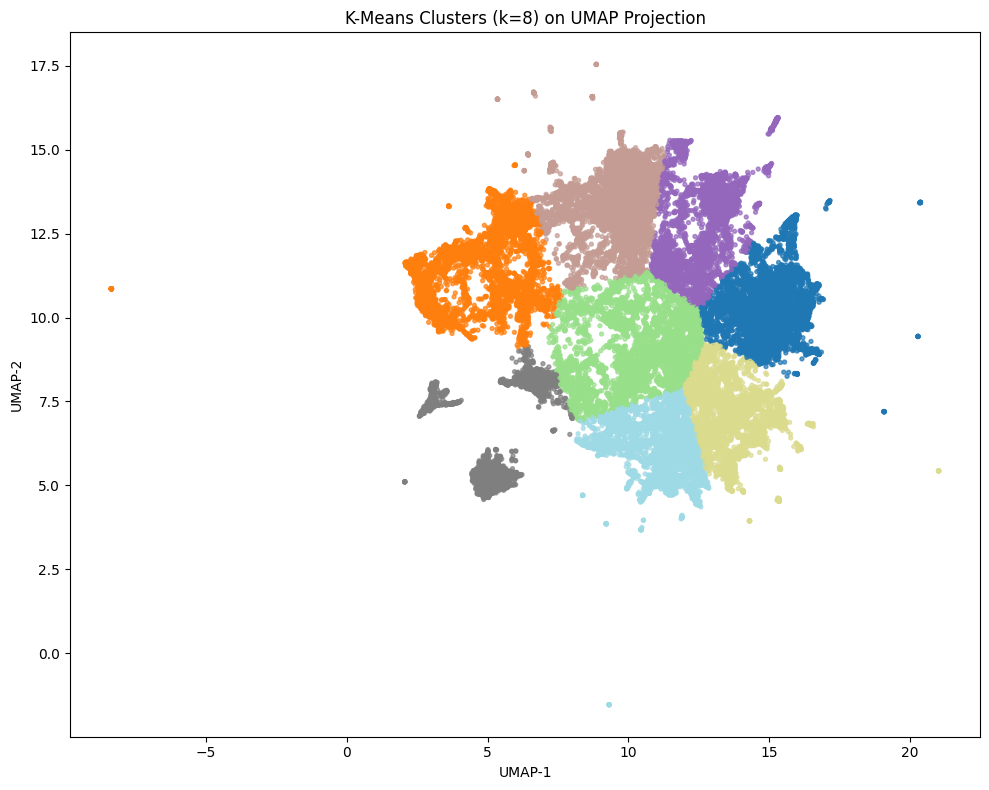

In [11]:
# Plot K-Means clusters on UMAP projection

plt.figure(figsize=(10,8))
plt.scatter(
    df["umap_x"], df["umap_y"],
    c=df["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title(f"K-Means Clusters (k={k}) on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


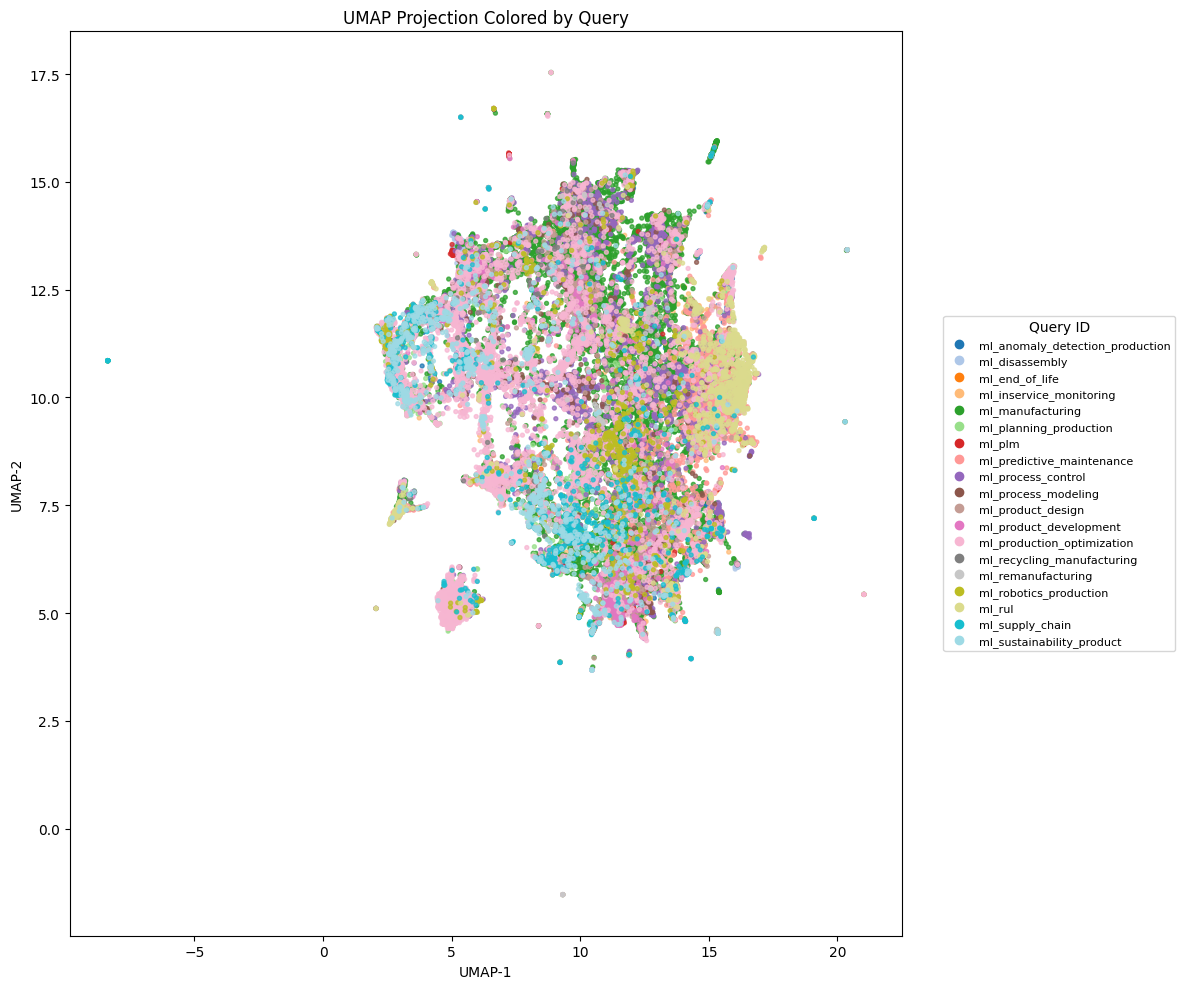

In [12]:
# Plot query_id distribution on UMAP projection

# Assign an integer color index to each query_id
query_ids = df["query_id"].astype("category")
query_labels = query_ids.cat.codes  # numeric mapping

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df["umap_x"], df["umap_y"],
    c=query_labels,
    cmap="tab20",   # adjust depending on number of queries (>20 => use tab20b + tab20c)
    s=8,
    alpha=0.75
)

# Legend mapping numeric labels → query_id names
handles = []
for code, name in enumerate(query_ids.cat.categories):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", 
                   color=scatter.cmap(scatter.norm(code)), label=name)
    )

plt.legend(
    handles=handles,
    title="Query ID",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.,
    fontsize=8
)

plt.title("UMAP Projection Colored by Query")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [18]:
domain_stopwords = {
    # Generic ML terms
    "machine learning", "deep learning", "data", "dataset", "model",
    "models", "method", "methods", "technique", "techniques",
    "approach", "algorithm", "algorithms", "neural network",
    "artificial neural network", "support vector machine",
    "random forest", "learning approach", "learning algorithms",
    "deep learning models", "convolutional neural network", 'machine learning approach', 
    'machine learning techniques', 'machine learning models', 'machine learning algorithms', 'machine learning methods', 
    'machine learning approach', 'neural network model', 'Support Vector Regression', 'extreme learning machine', 
    'learning models', 'advanced machine learning', 'machine learning tools',
    

    # Publisher names + garbage
    "springer nature switzerland", "springer nature singapore",
    "elsevier", "ieee", "wiley", "mdpi"
}

In [23]:
kw_extractor = yake.KeywordExtractor(
    lan="en",
    n=3,  # max length of keyword: allows bigrams & trigrams
    top=20,
    dedupLim=0.3
)

def get_cluster_keywords(cluster_id, top_k=10):
    texts = df[df["kmeans_cluster"] == cluster_id]["clean_abs"].tolist()
    full_text = " ".join(texts)
    
    keywords = kw_extractor.extract_keywords(full_text)
    keywords = [
        kw for kw, score in sorted(keywords, key=lambda x: x[1])
        if kw.lower() not in domain_stopwords
    ]
    
    return keywords[:top_k]

for cid in range(k):
    print(f"\nCluster {cid}:")
    print(get_cluster_keywords(cid, 12))




Cluster 0:


KeyboardInterrupt: 

In [ ]:
# Fit TF-IDF on all abstracts once
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 2),
    stop_words="english"
)
X = vectorizer.fit_transform(df["clean_abs"].astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())


In [25]:
def get_cluster_tfidf_keywords(cluster_id, top_k=10):
    # Boolean mask as numpy array (needed for sparse matrix indexing)
    mask = (df["kmeans_cluster"] == cluster_id).values
    if mask.sum() == 0:
        return []

    X_cluster = X[mask]

    # Mean TF-IDF score per term in this cluster
    mean_tfidf = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1]

    keywords = []
    for idx in top_idx:
        kw = feature_names[idx].lower()
        if kw in domain_stopwords:
            continue
        keywords.append(kw)
        if len(keywords) == top_k:
            break

    return keywords

# Test on a few clusters
for cid in range(k):
    print(f"\nCluster {cid}:")
    print(get_cluster_tfidf_keywords(cid, 12))


Cluster 0:
['maintenance', 'predictive', 'predictive maintenance', 'fault', 'failure', 'equipment', 'rul', 'detection', 'time', 'based', 'monitoring', 'industrial']

Cluster 1:
['food', 'production', 'crop', 'process', 'agricultural', 'ai', 'optimization', 'water', 'yield', 'ml', 'study', 'based']

Cluster 2:
['manufacturing', 'production', 'process', 'control', 'based', 'systems', 'scheduling', 'ai', 'optimization', 'time', 'quality', 'paper']

Cluster 3:
['process', 'manufacturing', 'quality', 'welding', 'defect', 'tool', 'based', 'machining', 'detection', 'inspection', 'defects', 'semiconductor']

Cluster 4:
['process', 'manufacturing', 'design', 'additive', 'materials', 'additive manufacturing', 'printing', 'material', 'properties', 'parameters', '3d', 'ml']

Cluster 5:
['energy', 'battery', 'production', 'reservoir', 'oil', 'gas', 'wells', 'optimization', 'solar', 'power', 'prediction', 'batteries']

Cluster 6:
['iot', 'systems', 'based', 'detection', 'security', 'network', 'ai',